https://www.youtube.com/watch?v=GXRveOki4kE


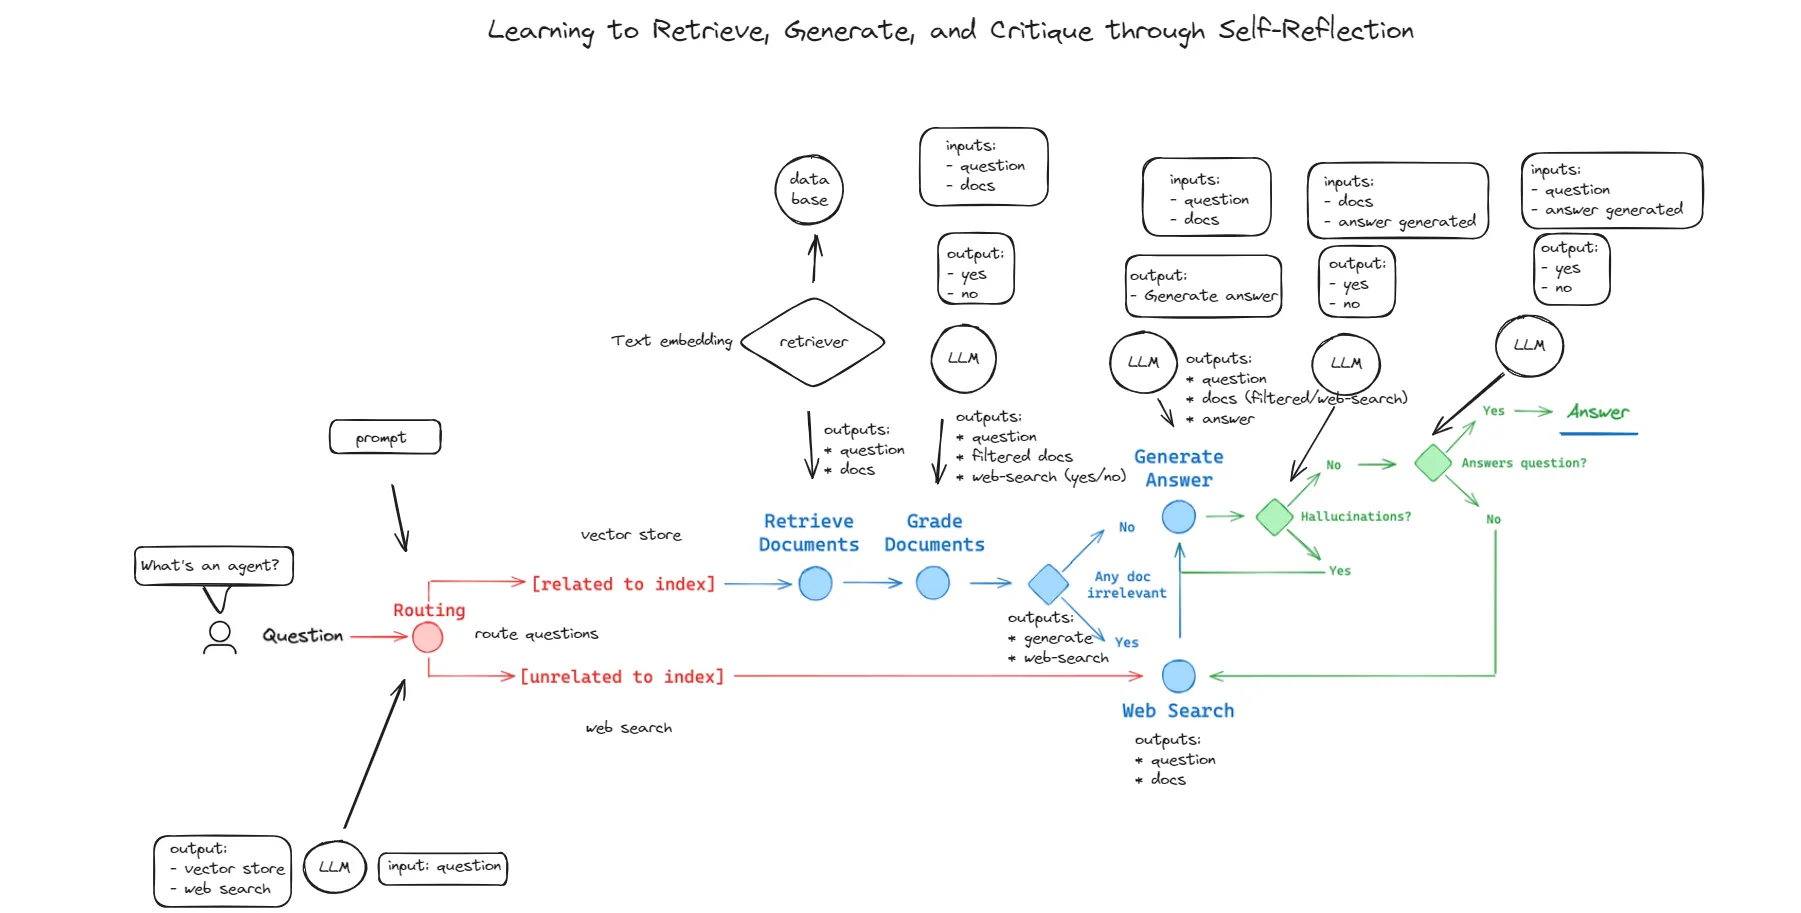


In [ ]:
import os
from dotenv import load_dotenv
load_dotenv()

In [ ]:
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
PINECONE_API_KEY = os.getenv("PINECONE_API_KEY")

model_version = "gpt-4o-mini"


In [ ]:
# print(f"TAVILY_API_KEY={TAVILY_API_KEY}")

In [ ]:
### Router

from typing import Literal

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field

from langchain_openai.chat_models import ChatOpenAI
from langchain_openai.embeddings import OpenAIEmbeddings
from langchain_pinecone import PineconeVectorStore

# Data model
class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource."""

    datasource: Literal["vectorstore", "websearch"] = Field(
        ...,
        description="Given a user question choose to route it to web search or a vectorstore.",
    )

# LLM with function call 
llm = ChatOpenAI(model=model_version, temperature=0)
structured_llm_router = llm.with_structured_output(RouteQuery)

# Prompt 
system = """You are an expert at routing a user question to a vectorstore or web search.
The vectorstore contains documents related to agents, prompt engineering, and adversarial attacks.
Use the vectorstore for questions on these topics. For all else, use web-search."""
route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

question_router = route_prompt | structured_llm_router
print(question_router.invoke({"question": "Who will the Bears draft first in the NFL draft?"}))
print(question_router.invoke({"question": "What are the types of agent memory?"}))

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader

urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs_list)
 
embeddings = OpenAIEmbeddings(openai_api_key=OPENAI_API_KEY)


In [ ]:
# example code

# # Add to vectorDB
# vectorstore = Chroma.from_documents(
#     documents=doc_splits,
#     collection_name="adv-rag-chroma",
#     embedding=embeddings,
# )
# retriever = vectorstore.as_retriever()

# Cargar los embeddings en Pinecone
index_name = "youtube-rag-index-selrefleting"

try:
    print("Removing data from pinecone")
    PineconeVectorStore.get_pinecone_index(index_name).delete(delete_all=True)
except:
    print("No database found...")

print("Storing new data in pinecone")
vectorstore = PineconeVectorStore.from_documents(
    doc_splits, embedding=embeddings, index_name=index_name#, pinecone_api_key=PINECONE_API_KEY, pinecone_environment=PINECONE_ENV
)

import sys
import time

wait = 10
print(f'tasks done, now sleeping for {wait} seconds')
for i in range(wait,0,-1):
    sys.stdout.write(str(i)+' ')
    sys.stdout.flush()
    time.sleep(1)

In [ ]:
retriever = vectorstore.as_retriever()

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
 
# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(description="Documents are relevant to the question, 'yes' or 'no'")

# LLM with function call 
structured_llm_grader_docs = llm.with_structured_output(GradeDocuments)

# Prompt 
system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""

grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

retrieval_grader_relevance = grade_prompt | structured_llm_grader_docs
question = "agent memory"
docs = retriever.invoke(question)
print(docs)
doc_txt = docs[1].page_content
print(retrieval_grader_relevance.invoke({"question": question, "document": doc_txt}))

In [ ]:
### Generate

from langchain_core.output_parsers import StrOutputParser

# Prompt
prompt = ChatPromptTemplate.from_template(
    """
    You are an assistant for question-answering tasks. 
    Use the following pieces of retrieved context to answer the question. 
    If you don't know the answer, just say that you don't know. 
    Use three sentences maximum and keep the answer concise.
Question: {question}
Context: {context}
Answer:"""
)
 
# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

In [ ]:
### Hallucination Grader 

# Data model
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: str = Field(description="Don't consider calling external APIs for additional information. Answer is supported by the facts, 'yes' or 'no'.")
 
# LLM with function call 
structured_llm_grader_hallucination = llm.with_structured_output(GradeHallucinations)
 
# Prompt 
system = """
You are a grader assessing whether an LLM generation 
is supported by a set of retrieved facts. \n 
Restrict yourself to give a binary score, either 'yes' or 'no'. 
If the answer is supported or partially supported by the set of facts, consider it a yes. \n
Don't consider calling external APIs for additional information as consistent with the facts."""

hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
]
)
  
hallucination_grader = hallucination_prompt | structured_llm_grader_hallucination
hallucination_grader.invoke({"documents": docs, "generation": generation})

In [ ]:
### Answer Grader 

# Data model
class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""

    binary_score: str = Field(description="Answer addresses the question, 'yes' or 'no'")

# LLM with function call 
structured_llm_grader_answer = llm.with_structured_output(GradeAnswer)

# Prompt 
system = """You are a grader assessing whether an answer addresses / resolves a question \n 
     Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question."""
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)

answer_grader = answer_prompt | structured_llm_grader_answer
answer_grader.invoke({"question": question,"generation": generation})

In [ ]:
from langchain_community.tools.tavily_search import TavilySearchResults
web_search_tool = TavilySearchResults(k=3)

In [ ]:
from typing_extensions import TypedDict
from typing import List

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        web_search: whether to add search
        documents: list of documents 
    """
    question : str
    generation : str
    web_search : str
    documents : List[str]

In [ ]:
from langchain.schema import Document

### Nodes

def retrieve(state):
    """
    Retrieve documents from vectorstore

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE from Vector Store DB---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}

def generate(state):
    """
    Generate answer using RAG on retrieved documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE Answer---")
    question = state["question"]
    documents = state["documents"]
    
    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}

def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question
    If any document is not relevant, we will set a flag to run web search

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Filtered out irrelevant documents and updated web_search state
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]
    
    # Score each doc
    filtered_docs = []
    web_search = "No"
    for d in documents:
        score = retrieval_grader_relevance.invoke({"question": question, "document": d.page_content})
        grade = score.binary_score
        # Document relevant
        if grade.lower() == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        # Document not relevant
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            # We do not include the document in filtered_docs
            # We set a flag to indicate that we want to run web search
            web_search = "Yes"
            continue
    return {"documents": filtered_docs, "question": question, "web_search": web_search}
    
def web_search(state):
    """
    Web search based based on the question

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Appended web results to documents
    """

    print("---WEB SEARCH. Append to vector store db---")
    question = state["question"]
    documents = state["documents"]

    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    if documents is not None:
        documents.append(web_results)
    else:
        documents = [web_results]
    return {"documents": documents, "question": question}

### Edges

def route_question(state):
    """
    Route question to web search or RAG 

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]
    source = question_router.invoke({"question": question})   
    if source.datasource == 'websearch':
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "websearch"
    elif source.datasource == 'vectorstore':
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"

def decide_to_generate(state):
    """
    Determines whether to generate an answer, or add web search

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    question = state["question"]
    web_search = state["web_search"]
    filtered_documents = state["documents"]

    if web_search == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print("---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, INCLUDE WEB SEARCH---")
        return "websearch"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"

def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke({"documents": documents, "generation": generation})
    grade = score.binary_score

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({"question": question,"generation": generation})
        grade = score.binary_score
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
    else:
        print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"

In [ ]:
from langgraph.graph import END, StateGraph

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("websearch", web_search) # web search # key: action to do
workflow.add_node("retrieve", retrieve) # retrieve
workflow.add_node("grade_documents", grade_documents) # grade documents
workflow.add_node("generate", generate) # generatae

workflow.add_edge("websearch", "generate") #start -> end of node
workflow.add_edge("retrieve", "grade_documents")

# Build graph
workflow.set_conditional_entry_point(
    route_question,
    {
        "websearch": "websearch",
        "vectorstore": "retrieve",
    },
)
 
workflow.add_conditional_edges(
    "grade_documents", # start: node
    decide_to_generate, # defined function
    {
        "websearch": "websearch", #returns of the function
        "generate": "generate",   #returns of the function
    },
)
workflow.add_conditional_edges(
    "generate", # start: node
    grade_generation_v_documents_and_question, # defined function
    {
        "not supported": "generate", #returns of the function
        "useful": END,               #returns of the function
        "not useful": "websearch",   #returns of the function
    },
)

# Compile
app = workflow.compile()

In [ ]:
from pprint import pprint
inputs = {"question": "Types of memory of an agent"}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["generation"])

In [ ]:
from pprint import pprint
inputs = {"question": "Which player was selected as the first pick in the NBA 2023 draft?"}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["generation"])